# KITTI Dataset Exploration

In [1]:
!pip install moviepy
!pip install numpy
!pip install pykitti
!pip install opencv-python

In [2]:
## prerequisites

#!pip3 install pykitti
#!pip3 install moviepy

# download the synced and rectified dataset. do not need the unsynced dataset
#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip

#wget http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_tracklets.zip


In [3]:
# unzip files
#import zipfile
#targetdir = "KITTI_data"
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_sync.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [4]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_calib.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [5]:
#with zipfile.ZipFile("/home/ubuntu/2011_09_26_drive_0001_tracklets.zip","r") as zip_ref:
#    zip_ref.extractall(targetdir)
#    print("done")

In [32]:
import numpy as np
import pykitti
import matplotlib.pyplot as plt

# Change this to the directory where you store KITTI data
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"

def load_dataset(date, drive, calibrated=False, frame_range=None):
    """
    Loads the dataset with `date` and `drive`.
    
    Parameters
    ----------
    date        : Dataset creation date.
    drive       : Dataset drive.
    calibrated  : Flag indicating if we need to parse calibration data. Defaults to `False`.
    frame_range : Range of frames. Defaults to `None`.

    Returns
    -------
    Loaded dataset of type `raw`.
    """
    dataset = pykitti.raw(basedir, date, drive)

    # Load the data
    if calibrated:
        dataset._load_calib()  # Calibration data are accessible as named tuples

    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline [m]: ' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]: ' + str(dataset.calib.b_rgb))

    return dataset

In [15]:
from source import parseTrackletXML as xmlParser

def load_tracklets_for_frames(n_frames, xml_path):
    """
    Loads dataset labels also referred to as tracklets, saving them individually for each frame.

    Parameters
    ----------
    n_frames    : Number of frames in the dataset.
    xml_path    : Path to the tracklets XML.

    Returns
    -------
    Tuple of dictionaries with integer keys corresponding to absolute frame numbers and arrays as values. First array
    contains coordinates of bounding box vertices for each object in the frame, and the second array contains objects
    types as strings.
    """
    #print(xml_path)
    tracklets = xmlParser.parseXML(xml_path)

    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    # loop over tracklets
    for i, tracklet in enumerate(tracklets):
        # this part is inspired by kitti object development kit matlab code: computeBox3D
        h, w, l = tracklet.size
        # in velodyne coordinates around zero point and without orientation yet
        trackletBox = np.array([
            [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]
        ])
        
        print(tracklets)
        # loop over all data in tracklet
        for translation, rotation, state, occlusion, truncation, amtOcclusion, amtBorders, absoluteFrameNumber in tracklet:
            # determine if object is in the image; otherwise continue
            if truncation not in (xmlParser.TRUNC_IN_IMAGE, xmlParser.TRUNC_TRUNCATED):
                continue
            # re-create 3D bounding box in velodyne coordinate system
            yaw = rotation[2]  # other rotations are supposedly 0
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([
                [np.cos(yaw), -np.sin(yaw), 0.0],
                [np.sin(yaw), np.cos(yaw), 0.0],
                [0.0, 0.0, 1.0]
            ])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8, 1)).T
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber] + [
                tracklet.objectType]

    return (frame_tracklets, frame_tracklets_types)

Load the dataset downloaded from [KITTI website](http://www.cvlibs.net/datasets/kitti/raw_data.php). 

[2011_09_26_drive_0001 (0.4 GB)](http://kitti.is.tue.mpg.de/kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)

* **Length**: 114 frames (00:11 minutes)
* **Image resolution**: `1392 x 512` pixels
* **Labels**: 12 Cars, 0 Vans, 0 Trucks, 0 Pedestrians, 0 Sitters, 2 Cyclists, 1 Trams, 0 Misc

In [33]:
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
date = '2011_09_26'
drive = '0048'
dataset = pykitti.raw(basedir, date, drive)

print(dataset._load_calib)

<bound method raw._load_calib of <pykitti.raw.raw object at 0x112ffb6d8>>


In [34]:
date = '2011_09_26'
drive = '0048'
dataset = load_dataset(date, drive,calibrated=True)


directory = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
tracklet_rects, tracklet_types = load_tracklets_for_frames(len(list(dataset.velo)), '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(directory,date, date, drive))


Drive: 2011_09_26_drive_0048_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600501

RGB stereo pair baseline [m]: 0.532725440079
Parsing tracklet file /Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.
[<source.parseTrackletXML.Tracklet object at 0x111fc6c18>, <source.parseTrackletXML.Tracklet object at 0x111fc6c50>, <source.parseTrackletXML.Tracklet object at 0x111fc6c88>, <source.parseTrackletXML.Tracklet object at 0x111fc6cc0>, <source.parseTrackletXML.Tracklet object at 0x111fc6cf8>, <source.parseTrackletXML.Tracklet object at 0x111fc6d30>, <source.parseTrackletXML.Tracklet object at 0x111fc6d68>, <source.parseTrackletXML.Tracklet object at 0x111fc6da0>]
[<

In [10]:
print(dataset.calib.T_cam3_imu)
print(dataset.calib.T_cam3_velo)

[[ 0.001  -1.      0.0043 -0.7846]
 [ 0.0084 -0.0043 -1.      0.7195]
 [ 1.      0.001   0.0084 -1.0891]
 [ 0.      0.      0.      1.    ]]
[[ 0.0002 -0.9999 -0.0106 -0.4734]
 [ 0.0104  0.0106 -0.9999 -0.0751]
 [ 0.9999  0.0001  0.0105 -0.2721]
 [ 0.      0.      0.      1.    ]]


In [ ]:
from source import dataset_utility as du

In [22]:
import numpy as np
def parse_string_variable(str):
    var_name = str.split(':')[0]
    after_colon_index = len(var_name) + 1
    value = str[after_colon_index:]
    return (var_name, value)

def read_lines_to_dict(raw_text):
    var_list = []
    for i, line in enumerate(raw_text):
        var_list.append(line.replace('\n', ''))
    for i, line in enumerate(raw_text):
        var_list[i] = parse_string_variable(line)
    return dict(var_list)

def read_files_by_lines(filename):
    assert type(filename) is str
    with open(filename, 'r') as cam_to_cam:
#         data = cam_to_cam.read().replace('\n', 'r')
        data = cam_to_cam.readlines()
    return read_lines_to_dict(data)

def replace_var_from_dict_with_shape(var_dict, key, shape):
    return np.array(var_dict[key]).reshape(shape)


# TODO: 
# 1 if calibration completely found?
# 2 if rectification available
# 3 Deal with delta_f delta_t

def loadCalibrationCamToCam(filename, verbose=False):
    assert type(filename) is str
    cam_dict = read_files_by_lines(filename)

    for key, value in cam_dict.items():
        if key == 'calib_time':
            cam_dict[key] = value
        else:
            array = []
            for i, string in enumerate(value.split(' ')[1:]):
                array.append(float(string))
            cam_dict[key] = array

    for i in range(0, 4):
        S_rect_0i = 'S_rect_0' + str(i)
        R_rect_0i = 'R_rect_0' + str(i)
        P_rect_0i = 'P_rect_0' + str(i)
        S_0i = 'S_0' + str(i)
        K_0i = 'K_0' + str(i)
        D_0i = 'D_0' + str(i)
        R_0i = 'R_0' + str(i)
        T_0i = 'T_0' + str(i)

        cam_dict[S_rect_0i] = replace_var_from_dict_with_shape(cam_dict, S_rect_0i, (1, 2))
        cam_dict[R_rect_0i] = replace_var_from_dict_with_shape(cam_dict, R_rect_0i, (3, 3))
        cam_dict[P_rect_0i] = replace_var_from_dict_with_shape(cam_dict, P_rect_0i, (3, 4))
        cam_dict[S_0i] = replace_var_from_dict_with_shape(cam_dict, S_0i, (1, 2))
        cam_dict[K_0i] = replace_var_from_dict_with_shape(cam_dict, K_0i, (3, 3))
        cam_dict[D_0i] = replace_var_from_dict_with_shape(cam_dict, D_0i, (1, 5))
        cam_dict[R_0i] = replace_var_from_dict_with_shape(cam_dict, R_0i, (3, 3))
        cam_dict[T_0i] = replace_var_from_dict_with_shape(cam_dict, T_0i, (3, 1))

    if verbose:
          print(S_rect_0i, cam_dict[S_rect_0i])
          print(R_rect_0i, cam_dict[R_rect_0i])
          print(P_rect_0i, cam_dict[P_rect_0i])
          print(S_0i, cam_dict[S_0i])
          print(K_0i, cam_dict[K_0i])
          print(D_0i, cam_dict[D_0i])
          print(R_0i, cam_dict[R_0i])
          print(T_0i, cam_dict[T_0i])
    return cam_dict

def loadCalibrationRigid(filename, verbose=False):
    assert type(filename) is str
    velo_dict = read_files_by_lines(filename)

    for key, value in velo_dict.items():
        if key == 'calib_time':
            velo_dict[key] = value
        else:
            array = []
            for i, string in enumerate(value.split(' ')[1:]):
                array.append(float(string))
            velo_dict[key] = array

    R = 'R'
    T = 'T'
    velo_dict[R] = replace_var_from_dict_with_shape(velo_dict, R, (3, 3))
    velo_dict[T] = replace_var_from_dict_with_shape(velo_dict, T, (3, 1))
    # Tr = [R, T; 0 0 0 1]
    Tr = np.vstack((np.hstack((velo_dict[R], velo_dict[T])), [0, 0, 0, 1]))
    velo_dict['Tr'] = Tr

    if verbose:
      print(R, velo_dict[R])
      print(T, velo_dict[T])
      print('Tr', velo_dict['Tr'])
    return velo_dict['Tr']

# TODO: Limit to 2D matrix
def project(p_in, T):
#   Dimension of data projection matrix
#    assert type(T) == 'numpy.ndarray'
#    assert type(p_in) == 'numpy.ndarray'
    dim_norm, dim_proj = T.shape

    p_in_row_count = p_in.shape[0]
#   Do transformation in homogenouous coordinates
    p2_in = p_in
    if p2_in.shape[1] < dim_proj:
        col_ones = np.ones(p_in_row_count)
        col_ones.shape = (p_in_row_count, 1)
# matlab:       p2_in[:, dim_proj - 1] = 1
        p2_in = np.hstack((p2_in, col_ones))
#   (T*p2_in')'
    p2_out = np.transpose(np.dot(T, np.transpose(p2_in)))
#   Normalize homogeneous coordinates
    denominator = np.outer(p2_out[:, dim_norm - 1], np.ones(dim_norm - 1))
#   Element wise division
    p_out = p2_out[:, 0: dim_norm-1]/denominator
    return p_out

In [176]:
%matplotlib inline
l_and = lambda *x: np.logical_and.reduce(x)
def convert_velo_cord_to_img(data_set, calib_dir,num_points = 5, cam=2, frame=0,tracklet = False):
    """
    Demostrates projection of the velodyne points into the image plane
    Parameters
    ----------
    dataset = data_set_velo
    base_dir  : Absolute path to sequence base directory (ends with _sync)
    calib_dir : Absolute path to directory that contains calibration files
    Returns
    -------
    """
#     0-based index
#     cam = 2
#     frame = 20
#     load calibration
# TODO: use os.path.join?
    calib = loadCalibrationCamToCam(calib_dir + 'calib_cam_to_cam.txt')
    Tr_velo_to_cam = loadCalibrationRigid(calib_dir + 'calib_velo_to_cam.txt')

#     Compute projection matrix velodyne->image plane
    R_cam_to_rect = np.eye(4, dtype=float)
    R_cam_to_rect[0: 3, 0: 3] = calib['R_rect_00']
    P_velo_to_img = np.dot(np.dot(calib['P_rect_0' + str(cam)], R_cam_to_rect), Tr_velo_to_cam)
#     print(type(R_cam_to_rect))
#     Load image and display
#   Load velodyne points
# Take 1 of 5 points for display speed
    #velo = data_set.velo[0:len(data_set.velo):5][0]
    #velo = data_set.velo[0]
#     print('data_set velo', data_set.velo[frame])
    print(frame)
    velo_data = data_set[frame]
    if tracklet: 
        velo_data = velo_data.transpose(1,0)
        velo = velo_data
    else:
        velo = velo_data[0:velo_data.shape[0]:num_points]
    
    #img_h, img_w, img_ch = dataset_rgb[frame].right.shape
    img_h, img_w, img_ch = 400,1500,3
    
    img_plane_depth = 5
    x_dir_pts = velo[:, 0]
    filtered_x_dir_indices = l_and((x_dir_pts > img_plane_depth))
#     .flatten to remove extra dimension
    indices = np.argwhere(filtered_x_dir_indices).flatten()
#     Depth (x) limited velodyne points
    velo = velo[indices, :]
#     Project to image plane (exclude luminance/intensity)
    velo_img = project(velo[:, 0:3], P_velo_to_img)
    
    return velo_img

In [24]:
def crop_velo_to_img_size(img_shape, velo_data):
    """
    Parameters:
    ----------
    img_size: camera image size
    velo_data :calibrated and project transformed lidar to camera data
    """
    img_h = img_shape[0]
    img_w = img_shape[1]
    img_dim_x_pts = velo_data[:, 0]
    img_dim_y_pts = velo_data[:, 1]
    
    x_filt = l_and((img_dim_x_pts < img_w), (img_dim_x_pts >= 0))
    y_filt = l_and((img_dim_y_pts < img_h), (img_dim_y_pts >= 0))
    filtered = l_and(x_filt, y_filt)
    indices = np.argwhere(filtered).flatten()
    
    img_dim_x_pts = img_dim_x_pts[indices]
    img_dim_y_pts = img_dim_y_pts[indices]
    return (img_dim_x_pts, img_dim_y_pts)

In [133]:
#dataset_velo[frame][velo_range, :] 
#dataset_velo[0:len(dataset_velo):5][0]
#dataset.velo(1)
#dataset.velo[0]
#dataset_velo
#type(dataset_rgb)


#tmp_dataset_rgb = list(dataset.rgb)

#type(tmp_dataset_rgb[frame][0].right)


dataset_rgb = list(dataset.rgb)

0


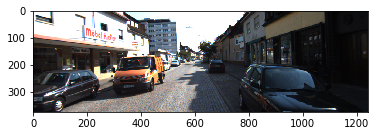

In [177]:
dataset_rgb = list(dataset.rgb)
frame = 0
calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"

#velo_data = convert_velo_cord_to_img(dataset, calib_dir)
velo_data = convert_velo_cord_to_img(dataset_velo, calib_dir)
#rgb_img = dataset.rgb[frame].right

rgb_img = dataset_rgb[frame][1]
plt.imshow(rgb_img)

0
<built-in function addWeighted>
(array([ 509.0394,  495.1266,  484.6391, ...,  645.5721,  634.7381,
        624.0674]), array([ 152.8008,  152.438 ,  152.1035, ...,  397.5292,  397.6026,
        397.7007]))


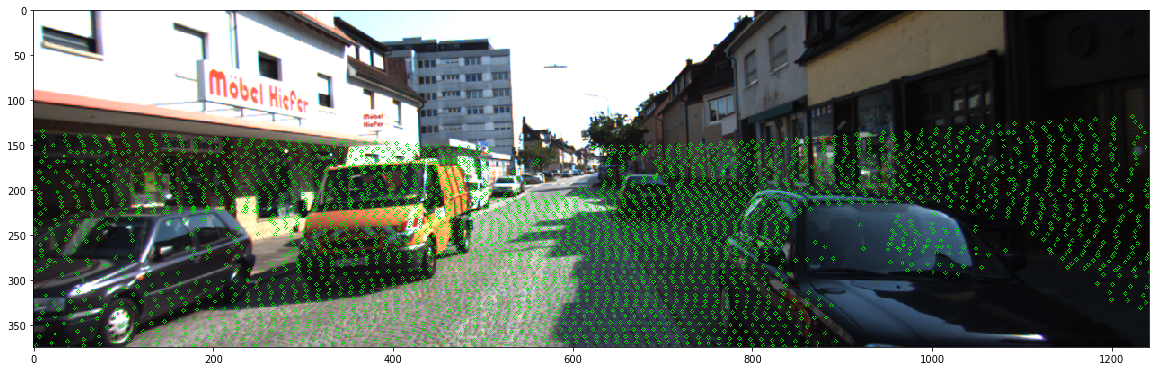

In [181]:

dataset_rgb = list(dataset.rgb)
frame = 0
calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"

#velo_data = convert_velo_cord_to_img(dataset, calib_dir)
velo_data = convert_velo_cord_to_img(dataset_velo, calib_dir)
#rgb_img = dataset.rgb[frame].right

rgb_img = dataset_rgb[frame][1]
#rgb_img = dataset.rgb[frame][0]
#rgb_img = dataset
#corped_velo_data = crop_velo_to_img_size(rgb_img.shape, velo_data)
corped_velo_data = crop_velo_to_img_size([400,1500,3], velo_data)


import cv2
print(cv2.addWeighted)
def overlay_velo_img(img, velo_data,radius = 2):
    (x, y) = velo_data
    im = np.zeros(img.shape, dtype=np.float32)
    x_axis = np.floor(x).astype(np.int32)
    y_axis = np.floor(y).astype(np.int32)
#     im[y_axis, x_axis] = [1, 0, 1]
    #print(len(x))
    #print(len(y))
    
    # below draws circles on the image
    for i in range(0, len(x)):
#         cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
            #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        #print(x_axis[i], y_axis[i])
        cv2.circle(img, (x_axis[i], y_axis[i]), radius, [0, 35, 0])
    
    fig1 = plt.figure(figsize=(20, 20))
    #plt.imshow(img)
    
    return img

result_img = overlay_velo_img(rgb_img, corped_velo_data,2)
print(corped_velo_data)
plt.imshow(result_img)

0
(array([ 517.7704,  417.3281,  320.6517,  476.789 ,  516.8382,  416.5401,
        319.6495,  475.4383]), array([ 263.9882,  265.3242,  312.1372,  309.8265,  162.9052,  163.9035,
        154.7138,  153.2153]))


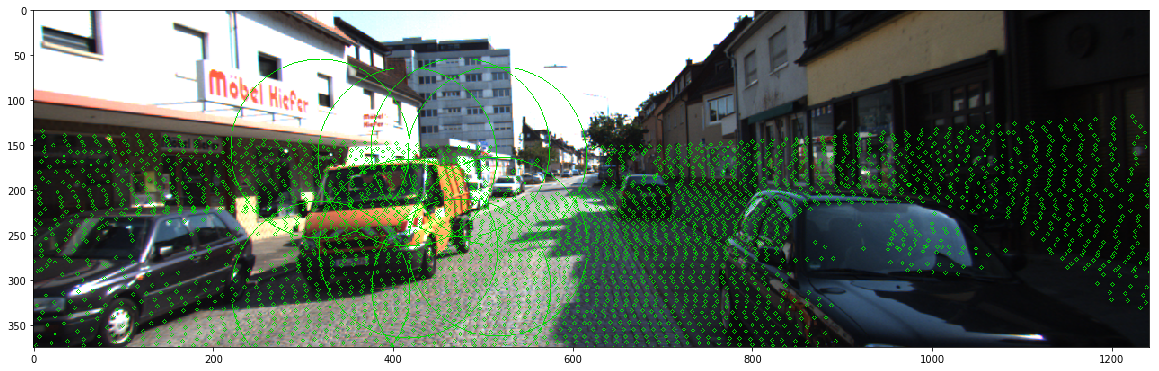

In [182]:
velo_data_tracklets = convert_velo_cord_to_img(dataset_tracklets, calib_dir,7, 2, 0,True)

corped_velo_data_tracklets = crop_velo_to_img_size([400,1500,3], velo_data_tracklets)

print(corped_velo_data_tracklets)
result_img_w_tracklets = overlay_velo_img(rgb_img, corped_velo_data_tracklets,100)

plt.imshow(result_img_w_tracklets)

#plt.scatter(corped_velo_data_tracklets[0],corped_velo_data_tracklets[1])

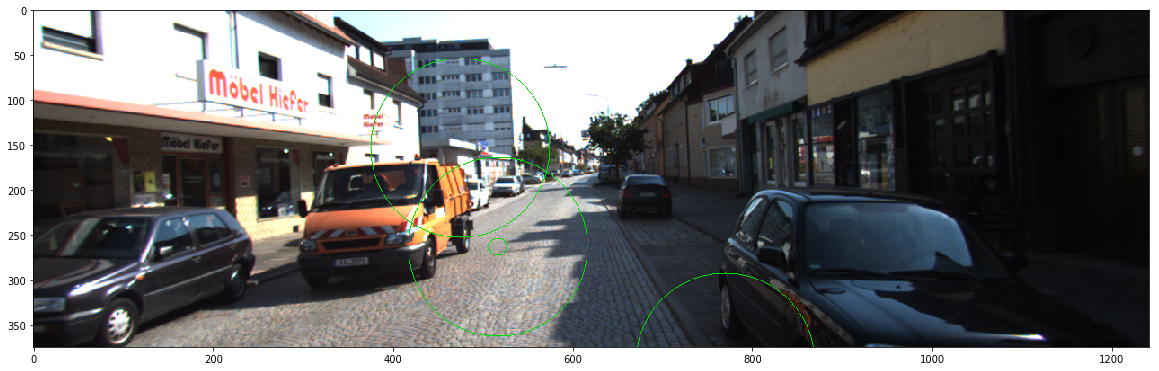

In [168]:
fig1 = plt.figure(figsize=(20, 20))

cv2.circle(rgb_img, (770, 392), 100, [0, 35, 0])
cv2.circle(rgb_img, (475, 153), 100, [0, 35, 0])

cv2.circle(rgb_img, (517, 263), 100, [0, 35, 0])

plt.imshow(rgb_img)

In [43]:
tracklet_rects[0][0]#[0].shape

tracklet_types[0][0]

'Van'

In [175]:
tracklet_rects[0][0].shape

(3, 8)

In [92]:
np.reshape(tracklet_rects[0][0],(8,3))

array([[ 14.8897,  14.841 ,   9.6623],
       [  9.711 ,  14.8897,  14.841 ],
       [  9.6623,   9.711 ,   1.9366],
       [  3.9564,   3.8316,   1.8118],
       [  1.9366,   3.9564,   3.8316],
       [  1.8118,  -1.7439,  -1.7439],
       [ -1.7439,  -1.7439,   0.3022],
       [  0.3022,   0.3022,   0.3022]])

In [96]:
print(tracklet_rects[0][0].transpose(1,0).shape)

(8, 3)


In [82]:
dataset_velo[0].shape

(119977, 4)

In [85]:
dataset_velo[0][10]

array([ 43.436,   7.526,   1.7  ,   0.   ], dtype=float32)

In [61]:
dataset_tracklets[0][0].shape

(3, 8)

In [79]:
test_data = dataset_tracklets[0][0]
test_data[0:test_data.shape[0]:8]

test_data

array([[ 14.8897,  14.841 ,   9.6623,   9.711 ,  14.8897,  14.841 ,
          9.6623,   9.711 ],
       [  1.9366,   3.9564,   3.8316,   1.8118,   1.9366,   3.9564,
          3.8316,   1.8118],
       [ -1.7439,  -1.7439,  -1.7439,  -1.7439,   0.3022,   0.3022,
          0.3022,   0.3022]])

In [110]:
# this is a good step. This is annotating with the bounding boxes. I would have expected 4 coordinates at least

#dataset_tracklets = tracklet_rects
dataset_tracklets = tracklet_rects[0]

#dataset_tracklets[0].shape
velo_data_tracklets = convert_velo_cord_to_img(dataset_tracklets, calib_dir,7, 2, 0,True)

velo_data_tracklets

0


array([[ 517.7704,  263.9882],
       [ 475.4383,  153.2153]])

In [ ]:
# below translates the tracklets into 2d -image

def convert_tracklet_velo_cord_to_img(data_set, calib_dir, cam=2, frame=20):
    # Get the translation matri
    calib = loadCalibrationCamToCam(calib_dir + 'calib_cam_to_cam.txt')
    Tr_velo_to_cam = loadCalibrationRigid(calib_dir + 'calib_velo_to_cam.txt')

    #     Compute projection matrix velodyne->image plane
    R_cam_to_rect = np.eye(4, dtype=float)
    R_cam_to_rect[0: 3, 0: 3] = calib['R_rect_00']
    P_velo_to_img = np.dot(np.dot(calib['P_rect_0' + str(cam)], R_cam_to_rect), Tr_velo_to_cam)

    velo_data = dataset_velo[frame]
    velo = velo_data[0:velo_data.shape[0]:5]

    img_h, img_w, img_ch = 400,1500,3

    img_plane_depth = 5
    x_dir_pts = velo[:, 0]
    filtered_x_dir_indices = l_and((x_dir_pts > img_plane_depth))
    #     .flatten to remove extra dimension
    indices = np.argwhere(filtered_x_dir_indices).flatten()
    #     Depth (x) limited velodyne points
    velo = velo[indices, :]
    #     Project to image plane (exclude luminance/intensity)
    velo_img = project(velo[:, 0:3], P_velo_to_img)
    
return velo_img


In [ ]:
# how to validate

# I think the tracklets can help. does it correctly map to the car?


def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

        
for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])